## **Install Basic Requirements**

In [ ]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 torchtext==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

## **Import Dependencies**

In [69]:
import os
import sys
import time
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

In [70]:
%matplotlib inline

In [71]:
image_dataset = pd.DataFrame(columns=["image", "quality"])

In [72]:
image_quality_path = "/content/good_quality_images/*.png"
for image_path in tqdm(glob.glob( image_quality_path )):
    image_dataset = image_dataset.append({"image":image_path,
                          "quality":1},
                         ignore_index=True)

100%|██████████| 500/500 [00:01<00:00, 359.96it/s]


In [73]:
image_dataset.head()

,image,quality
0,/content/good_quality_images/466.png,1
1,/content/good_quality_images/3356.png,1
2,/content/good_quality_images/4523.png,1
3,/content/good_quality_images/2132.png,1
4,/content/good_quality_images/139.png,1


In [74]:
image_quality_path = "/content/bad_quality_images/*.png"
for image_path in tqdm(glob.glob( image_quality_path )):
    image_dataset = image_dataset.append({"image":image_path,
                          "quality":0},
                         ignore_index=True)

100%|██████████| 7500/7500 [00:19<00:00, 387.56it/s]


In [75]:
image_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    8000 non-null   object
 1   quality  8000 non-null   object
dtypes: object(2)
memory usage: 125.1+ KB


In [76]:
image_dataset.describe()

,image,quality
count,8000,8000
unique,8000,2
top,/content/bad_quality_images/615_ja0.png,0
freq,1,7500


In [77]:
image_dataset.quality.value_counts()

0    7500
1     500
Name: quality, dtype: int64

## **Image Preprocessing**


In [78]:
img.imread(image_dataset.iloc[0,0]).shape

(96, 96, 3)

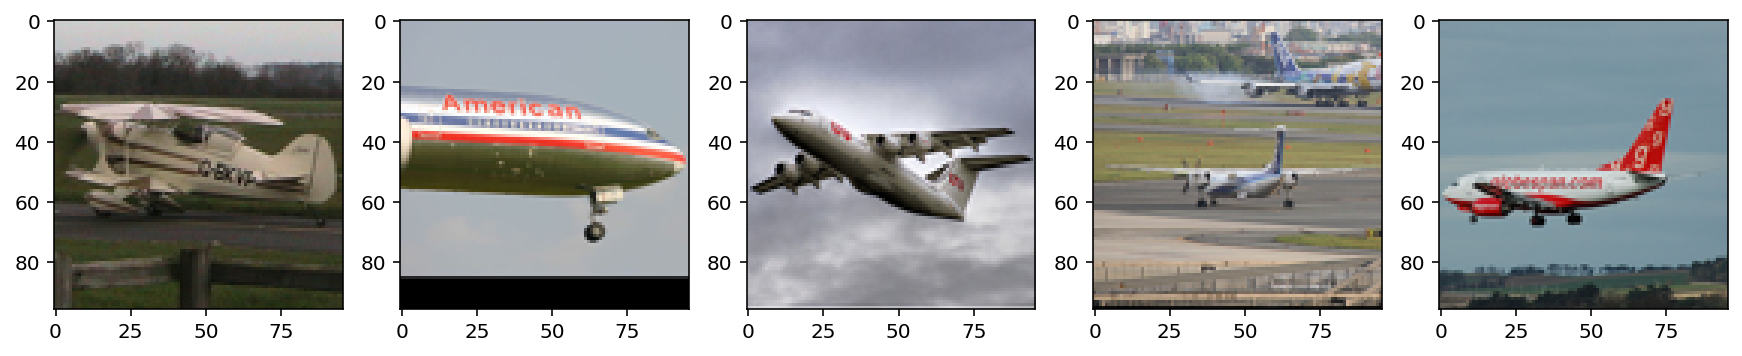

In [79]:
fig, ax = plt.subplots(1, 5, figsize=(15,5))

for i, idx in enumerate(image_dataset[ image_dataset['quality']==1 ]["image"][-5:]):
    ax[i].imshow( img.imread(idx) )

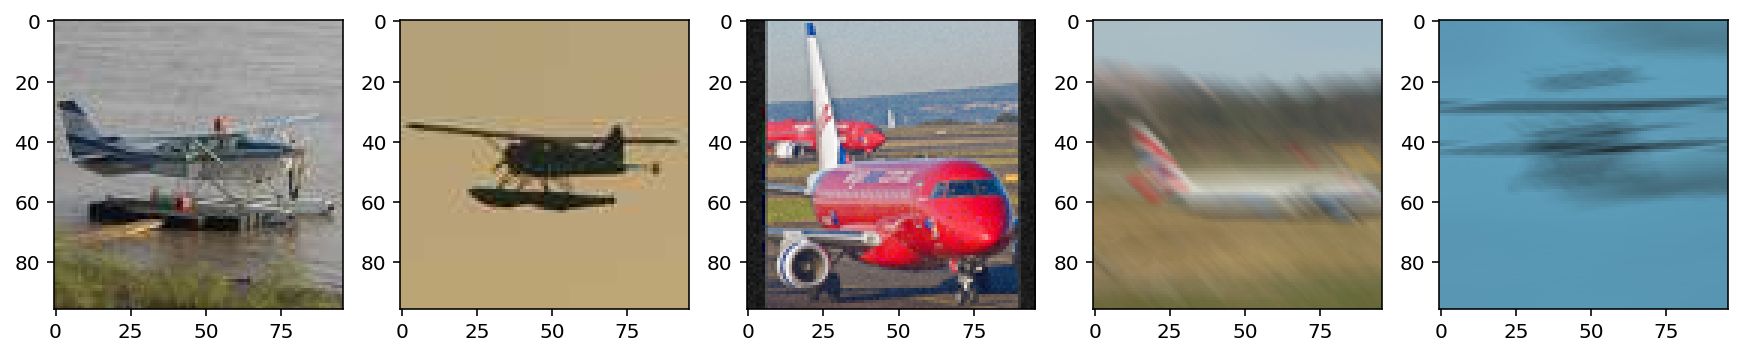

In [80]:
# Bad Quality Images
fig, ax = plt.subplots(1, 5, figsize=(15,5))

for i, idx in enumerate(image_dataset[ image_dataset['quality']==0 ]["image"][-5:]):
    ax[i].imshow( img.imread(idx) )

In [81]:
# Standardising Image

In [82]:
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1,2,0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.slip(image, 0, 1)
    
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=8)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [83]:
class QualityDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.values
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        img_path, label = self.data[index]
        image = img.imread(img_path)
        #print(f"image.shape -> {image.shape}")
        #if image.shape[2]==3:
            #image = image.T
        if self.transform is not None:
            image = self.transform(image)
            #pass
        
        return image, label

## **Normalization**

In [84]:
#means = [0.485, 0.456, 0.406]
means = [0.5, 0.5, 0.5]
#std = [0.229, 0.224, 0.225]
std = [0.5, 0.5, 0.5]

common_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=means, std=std)])

## **Splitting the Dataset**

In [85]:
train_valid_data, test_data = train_test_split(image_dataset, stratify=image_dataset.quality, test_size=0.05,
                                     random_state=0)
train_data, valid_data = train_test_split(train_valid_data, stratify=train_valid_data.quality, test_size=0.2,
                                     random_state=0)

In [86]:
train_data = QualityDataset(train_data, common_transform)
valid_data = QualityDataset(valid_data, common_transform)
test_data = QualityDataset(test_data, common_transform)

In [87]:
train_data.transform

Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [88]:
train_data.data

array([['/content/bad_quality_images/4186_mb4.png', 0],
       ['/content/bad_quality_images/3395_in3.png', 0],
       ['/content/bad_quality_images/2791_mb4.png', 0],
       ...,
       ['/content/bad_quality_images/553_ja3.png', 0],
       ['/content/good_quality_images/2054.png', 1],
       ['/content/bad_quality_images/1994_mb0.png', 0]], dtype=object)

In [89]:
train_data[0]

(tensor([[[-0.1216, -0.4431, -0.6392,  ..., -0.4431, -0.2549, -0.2471],
          [-0.1451, -0.4667, -0.6314,  ..., -0.4353, -0.2235, -0.2549],
          [-0.1765, -0.4902, -0.6235,  ..., -0.4510, -0.2235, -0.2627],
          ...,
          [-0.5608, -0.5843, -0.5922,  ..., -0.6706, -0.6784, -0.6706],
          [-0.5686, -0.5843, -0.6000,  ..., -0.6627, -0.6784, -0.6706],
          [-0.5922, -0.6078, -0.6078,  ..., -0.6627, -0.6706, -0.6784]],
 
         [[-0.0353, -0.3176, -0.4824,  ..., -0.4196, -0.2471, -0.2392],
          [-0.0588, -0.3333, -0.4745,  ..., -0.4118, -0.2235, -0.2549],
          [-0.0824, -0.3569, -0.4667,  ..., -0.4275, -0.2235, -0.2549],
          ...,
          [-0.2627, -0.2941, -0.3020,  ..., -0.4118, -0.4275, -0.4118],
          [-0.2706, -0.2941, -0.3098,  ..., -0.4118, -0.4275, -0.4196],
          [-0.3098, -0.3255, -0.3255,  ..., -0.4118, -0.4118, -0.4196]],
 
         [[ 0.0039, -0.2314, -0.3569,  ..., -0.3725, -0.2549, -0.2549],
          [-0.0196, -0.2471,

In [90]:
train_data[0][0].size()

torch.Size([3, 96, 96])

In [91]:
valid_data[0][0].size()

torch.Size([3, 96, 96])

In [92]:
test_data[0][0].size()

torch.Size([3, 96, 96])

In [93]:
# Define Hyperparameters

In [94]:
num_epochs = 50
num_classes = 2
batch_size = 25
learning_rate = 0.001

In [95]:
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [96]:
train_loader = DataLoader(dataset=train_data,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=0)
valid_loader = DataLoader(dataset=valid_data,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=0)
test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


training images



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 96, 96])


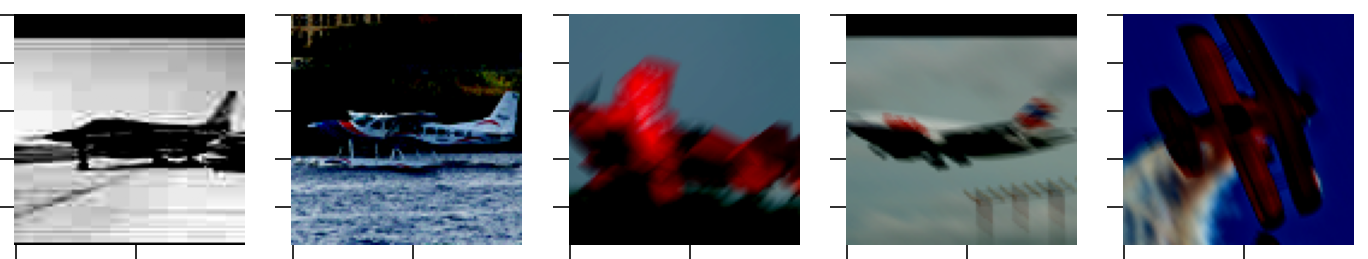

In [97]:
trainimages, trainlabels = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(12,12), ncols=5)
print(f"training images\n")
for i in range(5):
    axe1 = axes[i]
    imshow(trainimages[i], ax=axe1, normalize=None)

print(trainimages[0].shape)

## **Create Neural Network**

In [98]:
import torch.nn as nn
class QualityCNN_Network(nn.Module):
    def __init__(self):
        super(QualityCNN_Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(9680, 1024)
        self.fc2 = nn.Linear(1024, 2)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [99]:
model = QualityCNN_Network()
print(model)

QualityCNN_Network(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9680, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


In [100]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [101]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in tqdm(range(1, num_epochs + 1)):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

  2%|▏         | 1/50 [00:10<08:45, 10.72s/it]

Epoch: 1 	Training Loss: 0.296338 	Validation Loss: 0.234039


  4%|▍         | 2/50 [00:21<08:30, 10.63s/it]

Epoch: 2 	Training Loss: 0.264660 	Validation Loss: 0.256625


  6%|▌         | 3/50 [00:31<08:16, 10.56s/it]

Epoch: 3 	Training Loss: 0.249599 	Validation Loss: 0.241699


  8%|▊         | 4/50 [00:41<08:01, 10.47s/it]

Epoch: 4 	Training Loss: 0.245267 	Validation Loss: 0.230233


 10%|█         | 5/50 [00:52<07:49, 10.43s/it]

Epoch: 5 	Training Loss: 0.231568 	Validation Loss: 0.223500


 12%|█▏        | 6/50 [01:02<07:35, 10.34s/it]

Epoch: 6 	Training Loss: 0.231006 	Validation Loss: 0.236401


 14%|█▍        | 7/50 [01:12<07:23, 10.30s/it]

Epoch: 7 	Training Loss: 0.228094 	Validation Loss: 0.229508


 16%|█▌        | 8/50 [01:22<07:13, 10.32s/it]

Epoch: 8 	Training Loss: 0.228110 	Validation Loss: 0.226260


 18%|█▊        | 9/50 [01:33<07:02, 10.30s/it]

Epoch: 9 	Training Loss: 0.223659 	Validation Loss: 0.219733


 20%|██        | 10/50 [01:43<06:51, 10.28s/it]

Epoch: 10 	Training Loss: 0.222154 	Validation Loss: 0.224757


 22%|██▏       | 11/50 [01:53<06:42, 10.33s/it]

Epoch: 11 	Training Loss: 0.219913 	Validation Loss: 0.215561


 24%|██▍       | 12/50 [02:03<06:30, 10.28s/it]

Epoch: 12 	Training Loss: 0.215519 	Validation Loss: 0.214013


 26%|██▌       | 13/50 [02:14<06:19, 10.27s/it]

Epoch: 13 	Training Loss: 0.214517 	Validation Loss: 0.234626


 28%|██▊       | 14/50 [02:24<06:09, 10.27s/it]

Epoch: 14 	Training Loss: 0.214039 	Validation Loss: 0.216189


 30%|███       | 15/50 [02:34<05:59, 10.26s/it]

Epoch: 15 	Training Loss: 0.206577 	Validation Loss: 0.223255


 32%|███▏      | 16/50 [02:44<05:49, 10.27s/it]

Epoch: 16 	Training Loss: 0.205015 	Validation Loss: 0.220924


 34%|███▍      | 17/50 [02:55<05:39, 10.29s/it]

Epoch: 17 	Training Loss: 0.204814 	Validation Loss: 0.220520


 36%|███▌      | 18/50 [03:05<05:28, 10.25s/it]

Epoch: 18 	Training Loss: 0.203400 	Validation Loss: 0.221951


 38%|███▊      | 19/50 [03:15<05:17, 10.23s/it]

Epoch: 19 	Training Loss: 0.197406 	Validation Loss: 0.223149


 40%|████      | 20/50 [03:25<05:07, 10.24s/it]

Epoch: 20 	Training Loss: 0.198647 	Validation Loss: 0.218941


 42%|████▏     | 21/50 [03:36<04:58, 10.29s/it]

Epoch: 21 	Training Loss: 0.191857 	Validation Loss: 0.223327


 44%|████▍     | 22/50 [03:46<04:46, 10.25s/it]

Epoch: 22 	Training Loss: 0.187163 	Validation Loss: 0.231289


 46%|████▌     | 23/50 [03:56<04:36, 10.23s/it]

Epoch: 23 	Training Loss: 0.187183 	Validation Loss: 0.234310


 48%|████▊     | 24/50 [04:07<04:27, 10.29s/it]

Epoch: 24 	Training Loss: 0.187129 	Validation Loss: 0.247078


 50%|█████     | 25/50 [04:17<04:17, 10.30s/it]

Epoch: 25 	Training Loss: 0.181313 	Validation Loss: 0.249559


 52%|█████▏    | 26/50 [04:27<04:07, 10.29s/it]

Epoch: 26 	Training Loss: 0.181227 	Validation Loss: 0.234911


 54%|█████▍    | 27/50 [04:38<03:58, 10.36s/it]

Epoch: 27 	Training Loss: 0.182268 	Validation Loss: 0.232138


 56%|█████▌    | 28/50 [04:48<03:50, 10.47s/it]

Epoch: 28 	Training Loss: 0.170824 	Validation Loss: 0.246902


 58%|█████▊    | 29/50 [04:59<03:39, 10.46s/it]

Epoch: 29 	Training Loss: 0.167510 	Validation Loss: 0.247587


 60%|██████    | 30/50 [05:10<03:30, 10.52s/it]

Epoch: 30 	Training Loss: 0.162328 	Validation Loss: 0.245491


 62%|██████▏   | 31/50 [05:20<03:20, 10.55s/it]

Epoch: 31 	Training Loss: 0.153187 	Validation Loss: 0.248579


 64%|██████▍   | 32/50 [05:31<03:09, 10.52s/it]

Epoch: 32 	Training Loss: 0.165040 	Validation Loss: 0.252044


 66%|██████▌   | 33/50 [05:41<02:58, 10.48s/it]

Epoch: 33 	Training Loss: 0.153820 	Validation Loss: 0.268470


 68%|██████▊   | 34/50 [05:52<02:48, 10.52s/it]

Epoch: 34 	Training Loss: 0.154017 	Validation Loss: 0.228115


 70%|███████   | 35/50 [06:02<02:36, 10.44s/it]

Epoch: 35 	Training Loss: 0.148063 	Validation Loss: 0.252775


 72%|███████▏  | 36/50 [06:12<02:25, 10.37s/it]

Epoch: 36 	Training Loss: 0.145051 	Validation Loss: 0.256591


 74%|███████▍  | 37/50 [06:22<02:14, 10.38s/it]

Epoch: 37 	Training Loss: 0.144240 	Validation Loss: 0.286718


 76%|███████▌  | 38/50 [06:33<02:04, 10.34s/it]

Epoch: 38 	Training Loss: 0.137750 	Validation Loss: 0.281715


 78%|███████▊  | 39/50 [06:43<01:53, 10.34s/it]

Epoch: 39 	Training Loss: 0.131557 	Validation Loss: 0.283525


 80%|████████  | 40/50 [06:53<01:43, 10.36s/it]

Epoch: 40 	Training Loss: 0.132331 	Validation Loss: 0.303175


 82%|████████▏ | 41/50 [07:04<01:33, 10.35s/it]

Epoch: 41 	Training Loss: 0.127143 	Validation Loss: 0.272950


 84%|████████▍ | 42/50 [07:14<01:22, 10.37s/it]

Epoch: 42 	Training Loss: 0.136972 	Validation Loss: 0.252044


 86%|████████▌ | 43/50 [07:25<01:12, 10.35s/it]

Epoch: 43 	Training Loss: 0.121533 	Validation Loss: 0.307154


 88%|████████▊ | 44/50 [07:35<01:02, 10.39s/it]

Epoch: 44 	Training Loss: 0.110005 	Validation Loss: 0.351606


 90%|█████████ | 45/50 [07:45<00:51, 10.37s/it]

Epoch: 45 	Training Loss: 0.117720 	Validation Loss: 0.315917


 92%|█████████▏| 46/50 [07:56<00:41, 10.36s/it]

Epoch: 46 	Training Loss: 0.115298 	Validation Loss: 0.288715


 94%|█████████▍| 47/50 [08:06<00:31, 10.39s/it]

Epoch: 47 	Training Loss: 0.114894 	Validation Loss: 0.299298


 96%|█████████▌| 48/50 [08:16<00:20, 10.37s/it]

Epoch: 48 	Training Loss: 0.128240 	Validation Loss: 0.308093


 98%|█████████▊| 49/50 [08:27<00:10, 10.37s/it]

Epoch: 49 	Training Loss: 0.102358 	Validation Loss: 0.319728


100%|██████████| 50/50 [08:37<00:00, 10.36s/it]

Epoch: 50 	Training Loss: 0.102480 	Validation Loss: 0.392326
CPU times: user 7min 50s, sys: 47.5 s, total: 8min 38s
Wall time: 8min 37s


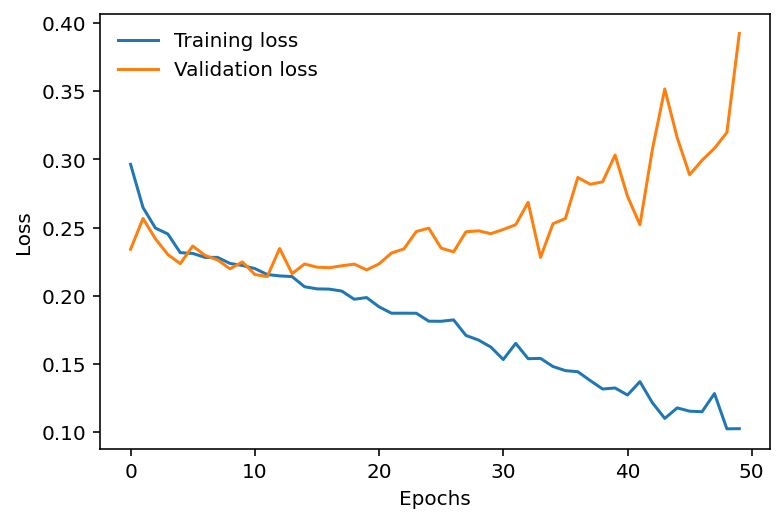

In [102]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

_ = plt.plot(train_losses, label='Training loss')
_ = plt.plot(valid_losses, label='Validation loss')
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")
_ = plt.legend(frameon=False)
plt.show()

In [103]:
# Model Overfiting after 10-15 epochs
# so train again with 13 epochs

In [104]:
%%time
model = QualityCNN_Network()
print(model)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)



# keeping-track-of-losses 
train_losses = []
valid_losses = []

num_epochs = 13

for epoch in tqdm(range(1, num_epochs + 1)):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

  0%|          | 0/13 [00:00<?, ?it/s]

QualityCNN_Network(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9680, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


  8%|▊         | 1/13 [00:10<02:04, 10.40s/it]

Epoch: 1 	Training Loss: 0.270410 	Validation Loss: 0.230791


 15%|█▌        | 2/13 [00:20<01:54, 10.42s/it]

Epoch: 2 	Training Loss: 0.248440 	Validation Loss: 0.235921


 23%|██▎       | 3/13 [00:31<01:44, 10.45s/it]

Epoch: 3 	Training Loss: 0.234876 	Validation Loss: 0.237490


 31%|███       | 4/13 [00:41<01:34, 10.45s/it]

Epoch: 4 	Training Loss: 0.229181 	Validation Loss: 0.279875


 38%|███▊      | 5/13 [00:52<01:23, 10.45s/it]

Epoch: 5 	Training Loss: 0.228157 	Validation Loss: 0.272487


 46%|████▌     | 6/13 [01:02<01:13, 10.45s/it]

Epoch: 6 	Training Loss: 0.224077 	Validation Loss: 0.243153


 54%|█████▍    | 7/13 [01:13<01:03, 10.51s/it]

Epoch: 7 	Training Loss: 0.224184 	Validation Loss: 0.217488


 62%|██████▏   | 8/13 [01:23<00:52, 10.48s/it]

Epoch: 8 	Training Loss: 0.223265 	Validation Loss: 0.239230


 69%|██████▉   | 9/13 [01:34<00:41, 10.47s/it]

Epoch: 9 	Training Loss: 0.219973 	Validation Loss: 0.242463


 77%|███████▋  | 10/13 [01:44<00:31, 10.47s/it]

Epoch: 10 	Training Loss: 0.221855 	Validation Loss: 0.230613


 85%|████████▍ | 11/13 [01:55<00:20, 10.46s/it]

Epoch: 11 	Training Loss: 0.219793 	Validation Loss: 0.222926


 92%|█████████▏| 12/13 [02:05<00:10, 10.46s/it]

Epoch: 12 	Training Loss: 0.216103 	Validation Loss: 0.210956


100%|██████████| 13/13 [02:15<00:00, 10.46s/it]

Epoch: 13 	Training Loss: 0.218212 	Validation Loss: 0.217564
CPU times: user 2min 1s, sys: 14.2 s, total: 2min 16s
Wall time: 2min 16s


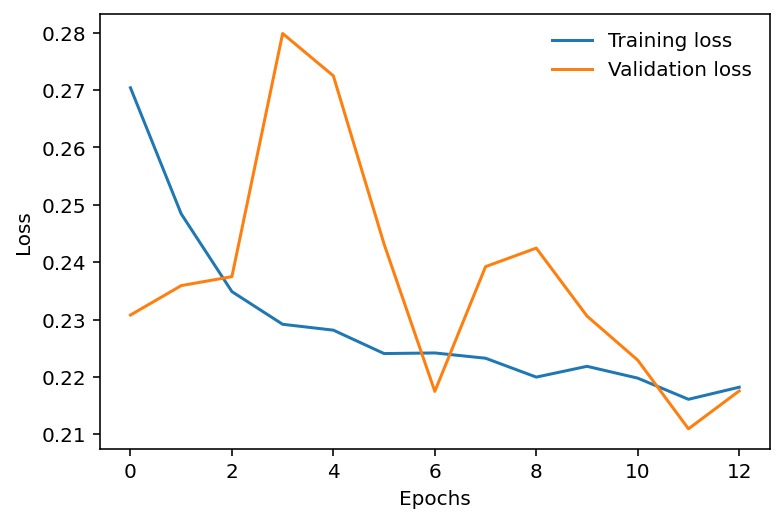

In [110]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

_ = plt.plot(train_losses, label='Training loss')
_ = plt.plot(valid_losses, label='Validation loss')
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")
_ = plt.legend(frameon=False)
plt.show()

In [111]:
# Evaluate the model
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Valid Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

Valid Accuracy of the model: 93.75 %


## **Results on Unseen Data**

In [112]:
# testing on unseen data
# test-the-model
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Test Accuracy of the model: 93.75 %
